# Sales Forecasting

At its core, a business's entire goal is to maximize one function: the profit function ($revenue - cost = profit$). Sounds easy, right? Unfortuneately, we live in a complex world with complex economies at multiple levels: global, national, state/province, city, and even neighborhood. This complexity creates risk, which means that there is an opportunity cost for every decision a business makes. Minimizing those opportunity costs is often best done through planning for the future. Just like it's wise to have a budget, track your personal expenses, and plan for the future, a business is only as successful as its ability to plan. One of the most common types of business planning is sales forecasting: the process of predicting future sales based on historical data, market trends, and economic conditions. Sales forecasting serves as a critical planning tool that helps businesses predict demand, maximize resource allocation efficiency, and set realistic financial and operational goals (the latter being especially crucial for public companies). Accurate sales forecasting enables companies to manage inventory, optimizing staffing, and align marketing and production efforts with anticipated demand, all leading to minimized opportunity costs. By identifying trends and potential shortfalls early, businesses can proactively address challenges, capitalize on opportunities, and make informed data-driven decisions that reduce risk and increase leverage.

Sales forecasting was historically done with manual methods and basic statistical techniques like trend analysis and moving averages. These approaches were simple due to the limited computing power of the day, and often didn't account for external factors like seasonality or market changes. As compute cost grew cheaper and cheaper, more sophisticated methods were introduced: regression models, time series analysis (ARIMA), and machine learning models. Today, the latest and greatest forecasting leverages advanced data modelling and representation techniques, which enable a statistical model to capture complex patterns and relationships in massive, high dimensional datasets. Even more recently, innovations like RNNs and transformers have enabled businesses to model external variables like macroeconomic trends, customer sentiment, and even weather data!

In this notebook, we'll look at 3 different methods of sales forecasting for retail stores, starting with the simplest and growing to the most complex:
1. Linear Regression
2. Time Series Models: SARIMA
3. Deep Learning Architechtures: LSTM/Transformer
4. Bonus: Prophet by Meta

## Importing Libraries and Data

We'll be using one dataset throughout this whole notebook: the Rossman Store Sales dataset, from a 2015 Kaggle competition hosted by Rossman. You can find the overview [here](https://www.kaggle.com/competitions/rossmann-store-sales/overview). 

Rossman is a pharmacy chain with about 3,000 stores across 7 European countries. We want to forecast sales for 6 weeks into the future for each of the stores represented in our dataset.

In [16]:
# pip install pandas matplotlib "numpy<2.0" seaborn tqdm scikit-learn statsmodels torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # "numpy<2.0" for Torch compatibility
import seaborn as sns
sns.set_style('whitegrid')

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [17]:
df = pd.read_csv("train.csv", parse_dates=[2])
store_data = pd.read_csv("store.csv")
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [18]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [19]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,,,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,,,NaN
4,5,a,a,29910,4,2015,0,,,NaN


Our primary data source has 9 columns:
1. Store: store ID
2. DayOfWeek: Day of the week represented (1 = Monday, 7 = Sunday)
3. Date: Date of sales represented
4. Sales: Amount of sales in Euros
5. Customers: Count of customers in the store
6. Open: Binary 0/1 representing whether or not the store was open
7. Promo: Binary 0/1 representing whether or not the store was running a promo
8. StateHoliday: Represents whether or not the date was a state holiday: a = public holiday, b = Easter, c = Christmas, 0 = None
9. SchoolHoliday: Binary 0/1 representing whether or not (Store @ Date)'s schools were closed

We also have a 'store' data source that contains info about each store location:
1. Store: Store ID
2. StoreType: Represents 4 different store models: a, b, c, d
3. Assortment: Represents level of inventory assortment/diversity: a = basic, b = extra, c = extended
4. CompetitionDistance: Distance in meters to the nearest competitor store
5. CompetitionOpenSinceMonth: Month that the nearest competitor store was opened
6. CompetitionOpenSinceYear: Year that the nearest competitor store was opened
7. Promo2: Indicates participation in a continuing and consecutive promotion
8. Promo2SinceWeek: Week that the store started Promo2
9. Promo2SinceYear: Year that the store started Promo2
10. PromoInterval: Represents the consecutive intervals Promo2 is started (Feb, May, Aug means that the promo starts anew in Feb, May, and Aug)

## Preprocessing

Let's start by looking at the distribution of each variable and checking for nulls: 

In [20]:
df.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01


In [21]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

We're dealing with time series data, so it's a good idea to set the Date column to be the df index. We'll also split up the date into separate year, month, and day features: 

In [22]:
df.set_index('Date', inplace=True)

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['WeekOfYear'] = df.index.strftime("%V")
df['WeekOfYear'] = pd.to_numeric(df['WeekOfYear'], errors='coerce')

df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


Let's also check out the store data source:

In [23]:
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                544
dtype: int64

Looks like we have some missing data in PromoInterval. Let's just impute an empty string there:

In [24]:
store_data['PromoInterval'].fillna("", inplace=True)
store_data.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [25]:
store_data.dtypes

Store                         int64
StoreType                    object
Assortment                   object
CompetitionDistance          object
CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
Promo2                        int64
Promo2SinceWeek              object
Promo2SinceYear              object
PromoInterval                object
dtype: object

In [26]:
for col in store_data.columns:
    print(f"{col}:\n {store_data[col].unique()}")

Store:
 [   1    2    3 ... 1113 1114 1115]
StoreType:
 ['c         ' 'a         ' 'd         ' 'b         ']
Assortment:
 ['a          ' 'c          ' 'b          ']
CompetitionDistance:
 ['1270' '570' '14130' '620' '29910' '310' '24000' '7520' '2030' '3160'
 '960' '1070' '1300' '4110' '3270' '50' '13840' '3240' '2340' '550' '1040'
 '4060' '4590' '430' '2300' '60' '1200' '2170' '40' '9800' '2910' '1320'
 '2240' '7660' '540' '4230' '1090' '260' '180' '1180' '290' '4880' '9710'
 '270' '1060' '18010' '6260' '10570' '450' '30360' '7170' '720' '6620'
 '420' '7340' '2840' '5540' '350' '2050' '3700' '22560' '410' '250' '1130'
 '4840' '17500' '2200' '1650' '330' '22440' '19960' '3510' '3320' '7910'
 '2370' '22390' '2710' '11810' '1870' '480' '560' '10690' '2380' '2410'
 '240' '16690' '14620' '1890' '8780' '8980' '15140' '17930' '2440' '150'
 '5210' '390' '6190' '1390' '1930' '2190' '3300' '46590' '7890' '1630'
 '20930' '4510' '5740' '680' '3450' '3580' '2100' '2290' '3570' '58260'
 '16760' '1

Looks like multiple columns have values with significant whitespace. Let's strip that out and impute the mean value if the col is intended to be numeric:

In [27]:
whitespace_str_cols = ['StoreType', 'Assortment']
whitespace_num_cols = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']

valid_str_values = {"a", "b", "c", "d"}

# Loop through the columns and coerce the values
for col in whitespace_str_cols:
    store_data[col] = store_data[col].apply(lambda x: next((v for v in valid_str_values if v in str(x).lower()), np.nan))
    print(f"{col}:\n {store_data[col].unique()}")

for col in whitespace_num_cols:
    store_data[col] = store_data[col].replace(['                         ', '                    ', '                '], np.nan)
    store_data[col] = store_data[col].apply(pd.to_numeric, errors='coerce')
    store_data[col] = store_data[col].fillna(round(store_data[col].mean()))
    store_data[col] = store_data[col].astype(int)
    print(f"{col}:\n {store_data[col].unique()}")

StoreType:
 ['c' 'a' 'd' 'b']
Assortment:
 ['a' 'c' 'b']
CompetitionDistance:
 [ 1270   570 14130   620 29910   310 24000  7520  2030  3160   960  1070
  1300  4110  3270    50 13840  3240  2340   550  1040  4060  4590   430
  2300    60  1200  2170    40  9800  2910  1320  2240  7660   540  4230
  1090   260   180  1180   290  4880  9710   270  1060 18010  6260 10570
   450 30360  7170   720  6620   420  7340  2840  5540   350  2050  3700
 22560   410   250  1130  4840 17500  2200  1650   330 22440 19960  3510
  3320  7910  2370 22390  2710 11810  1870   480   560 10690  2380  2410
   240 16690 14620  1890  8780  8980 15140 17930  2440   150  5210   390
  6190  1390  1930  2190  3300 46590  7890  1630 20930  4510  5740   680
  3450  3580  2100  2290  3570 58260 16760  1410   760  3370  1350  2000
  2460   900   920  5190  1730 25360  1700  1540  2930 16570   280  8050
  8540  2090  2610 31830  4360  1780 16240 16420  3050  2020  2950 11840
  8530 17110  2970  5340  1480  1160  3720   

While we're at it, let's check our main df for excessive whitespace:

In [28]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

Store: [   1    2    3 ... 1113 1114 1115]
DayOfWeek: [5 4 3 2 1 7 6]
Sales: [ 5263  6064  8314 ...   660 17815 23303]
Customers: [ 555  625  821 ... 3900   36 4065]
Open: [1 0]
Promo: [1 0]
StateHoliday: ['0' 'a            ' 'b            ' 'c            ' 0]
SchoolHoliday: [1 0]
Year: [2015 2014 2013]
Month: [ 7  6  5  4  3  2  1 12 11 10  9  8]
Day: [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1]
WeekOfYear: [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36
 35 34 33 32]


Looks like StateHoliday has the same problem. Let's fix those values in the same way:

In [29]:
valid_state_holiday_values = {"0", "a", "b", "c"}
df['StateHoliday'] = df['StateHoliday'].apply(lambda x: next((v for v in valid_state_holiday_values if v in str(x).lower()), np.nan))
print(f"StateHoliday: {df['StateHoliday'].unique()}")

StateHoliday: ['0' 'a' 'b' 'c']


Finally, let's merge everything together:

In [30]:
full_data = pd.merge(df, store_data, how='inner', on='Store') # merge data if store data is available
full_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,31,c,a,1270,9,2008,0,24,2012,
1,2,5,6064,625,1,1,0,1,2015,7,...,31,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,31,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,31,c,c,620,9,2009,0,24,2012,
4,5,5,4822,559,1,1,0,1,2015,7,...,31,a,a,29910,4,2015,0,24,2012,


## EDA

We know that there are 4 different types of stores, so let's see how Sales is distributed amongst each store type:

In [31]:
full_data.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


StoreType b has almost double the average sales of the other store types, but we have far fewer stores of that type. StoreType a is the most common, and also has the highest max Sales value. Let's check overall totals of Sales and Customers across store types:

In [32]:
full_data.groupby('StoreType')[['Customers', 'Sales']].sum()

,Customers,Sales
StoreType,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly, store type a is the busiest and generates the most sales, and type d is a distant second. What about date ranges?

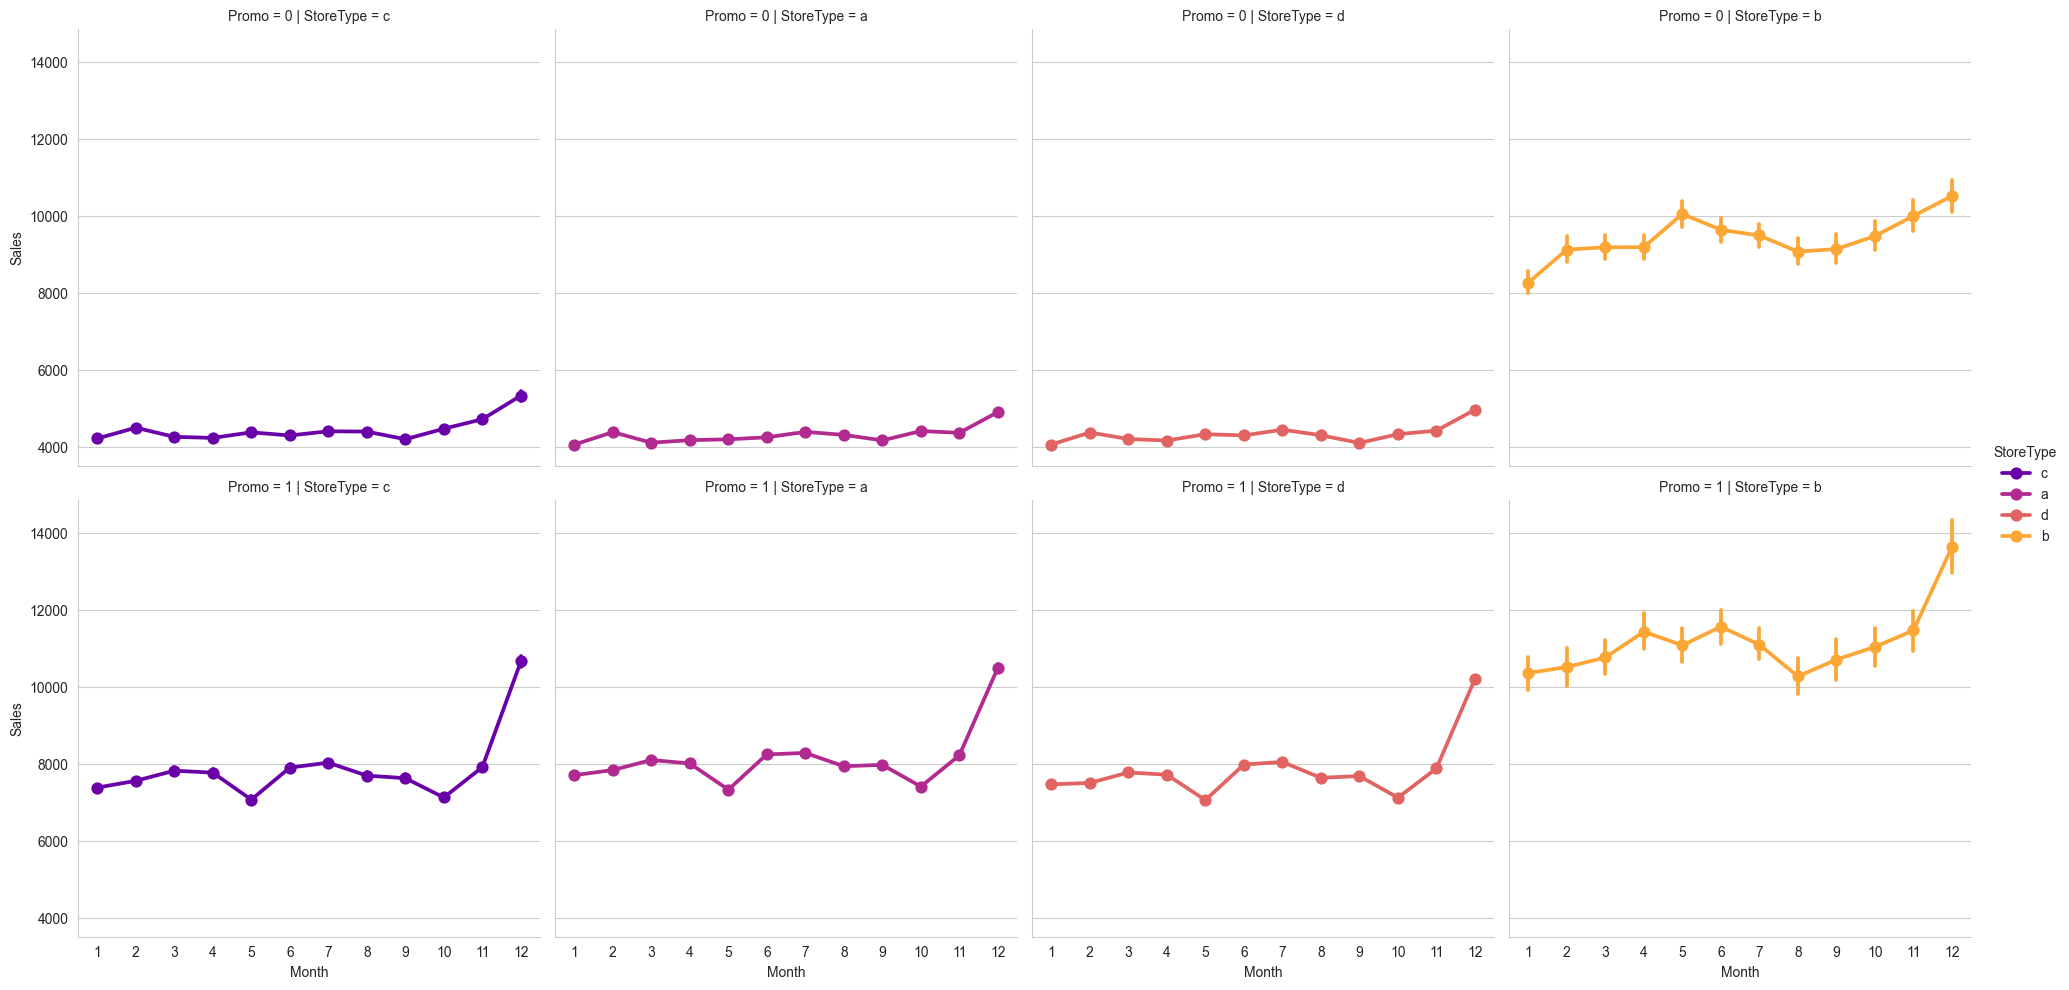

In [33]:
sns.catplot(data = full_data, x = 'Month', y = "Sales", 
            kind="point",
            col = 'StoreType', # store type in cols
            palette = 'plasma',
            hue = 'StoreType',
            row = 'Promo') # promo in rows

Let's do a quick check on sales per customer:

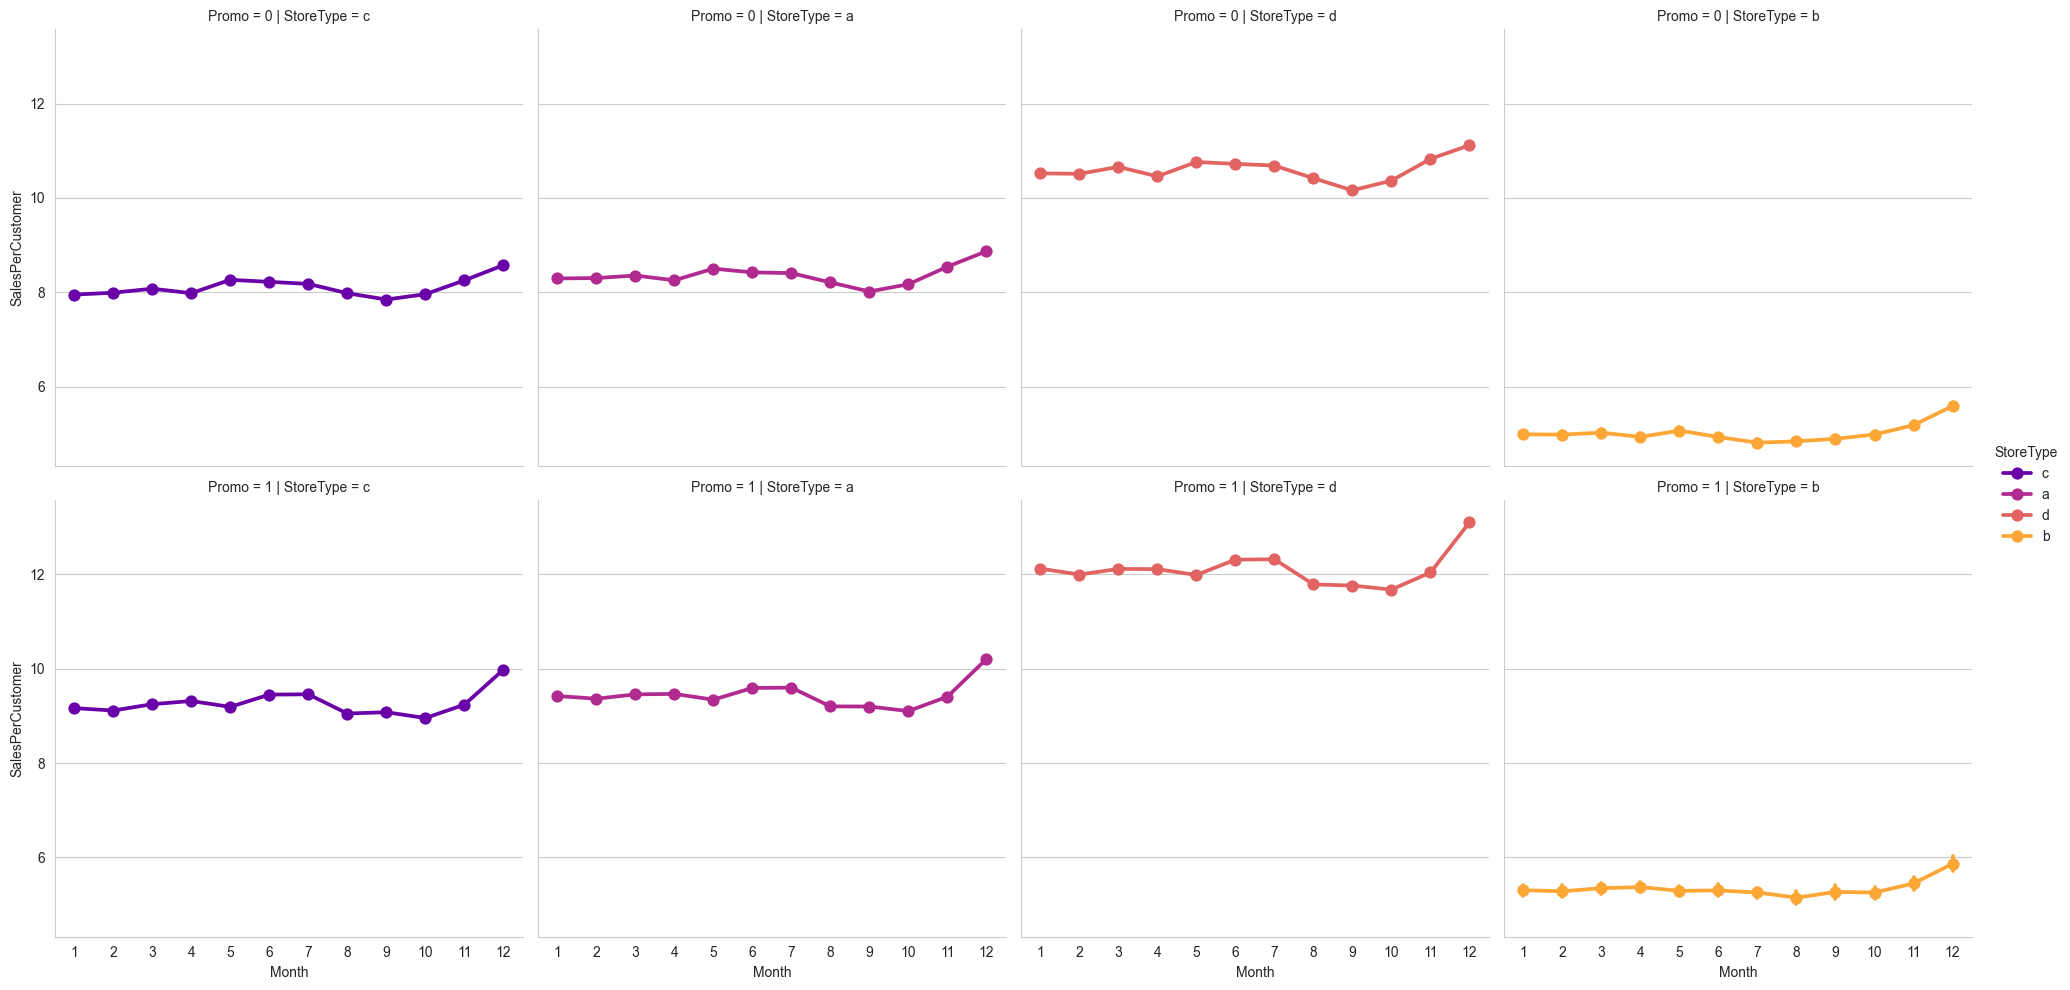

In [34]:
full_data['SalesPerCustomer'] = full_data['Sales'] / full_data['Customers']

sns.catplot(data = full_data, x = 'Month', y = "SalesPerCustomer", 
            kind="point",
            col = 'StoreType', # store type in cols
            palette = 'plasma',
            hue = 'StoreType',
            row = 'Promo') # promo in rows

Ah, this is interesting! Although store type a has the highest sales overall and highest customer traffic, store type d actually has the highest sales per customer: around 12 euros during promotions. Promotions clearly improve sales totals by a significant amount. Let's dive in deeper and look at sales across store types for each day of the week:

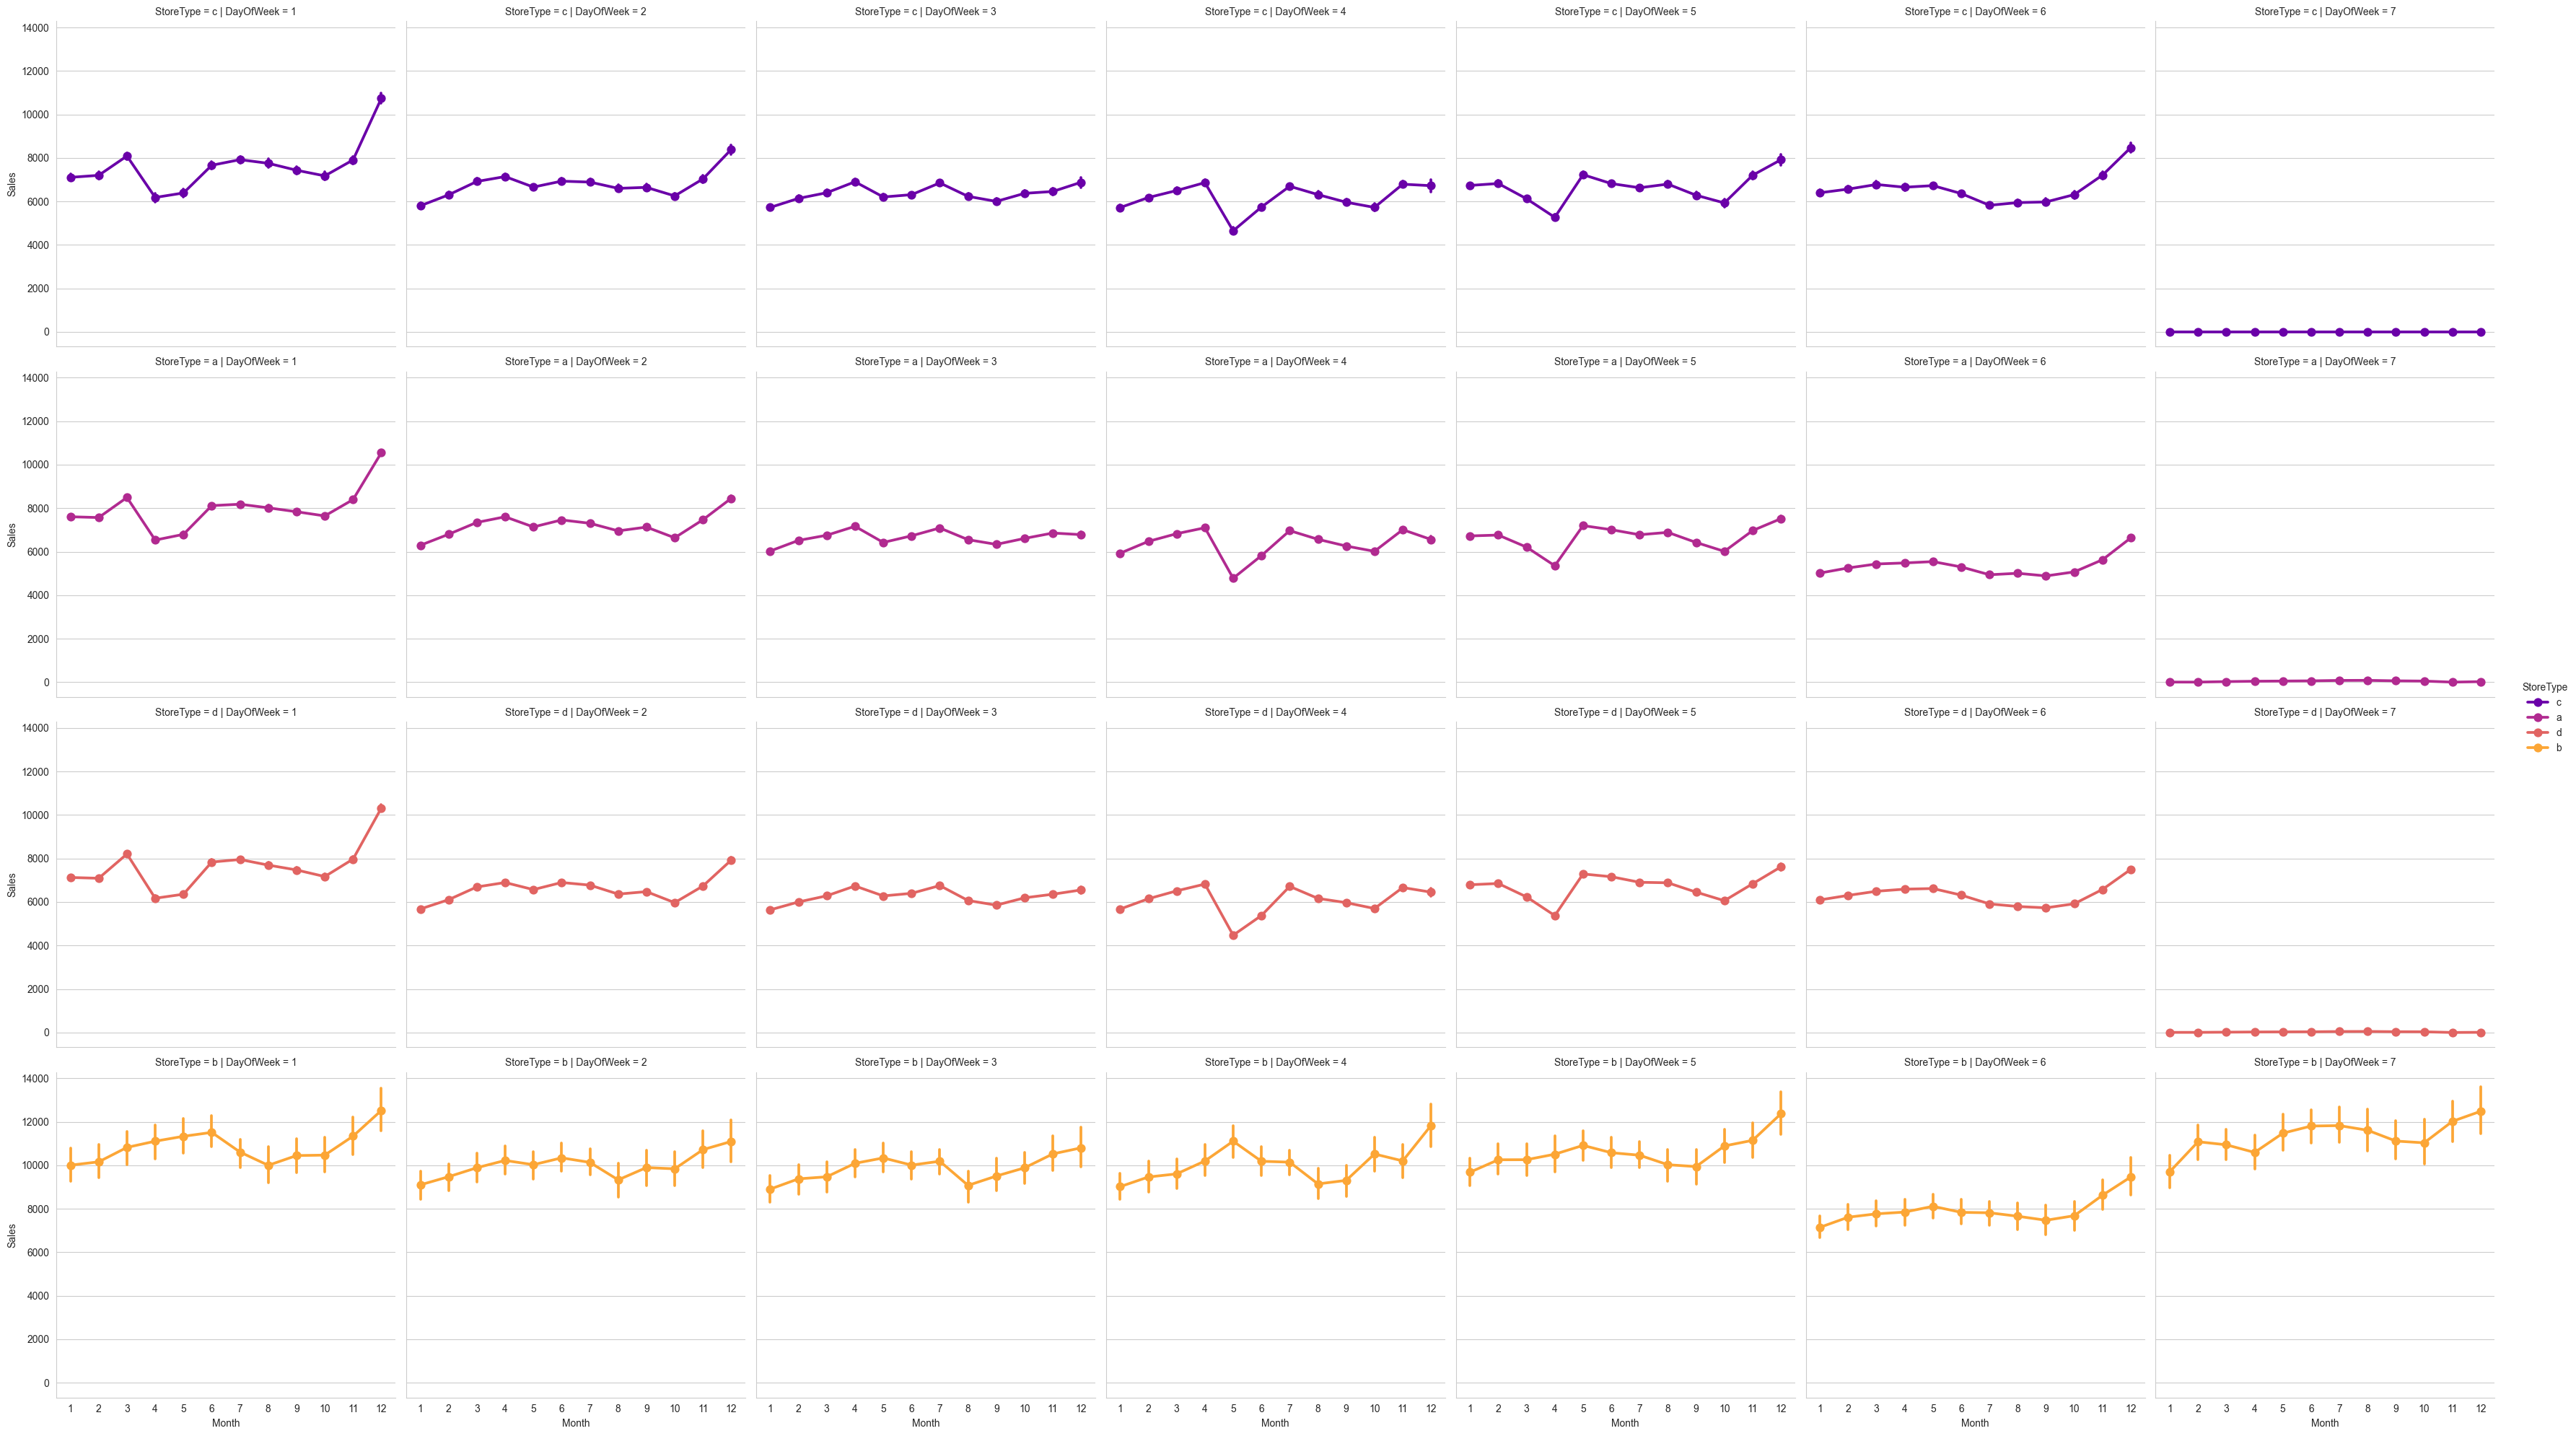

In [35]:
sns.catplot(data = full_data, x = 'Month', y = "Sales", 
            kind='point',
            col = 'DayOfWeek', # day of week in cols
            palette = 'plasma',
            hue = 'StoreType',
            row = 'StoreType') # store type in rows

Interesting--store type b is open on Sundays, while all other store types are closed. Store types a, c, and d all seem to follow similar trends across a year, but store type b runs its own course. 

Let's add some features to better represent exposure to competition and usage of promotions:

In [ ]:
# Competition open time (in months)
full_data['CompetitiveExposureMonths'] = 12 * (full_data['Year'] - full_data['CompetitionOpenSinceYear']) + \
        (full_data['Month'] - full_data['CompetitionOpenSinceMonth'])
    
# Promo open time (in months)
full_data['PromoRunningMonths'] = 12 * (full_data['Year'] - full_data['Promo2SinceYear']) + \
        (full_data['WeekOfYear'] - full_data['Promo2SinceWeek']) / 4.0

# Replace NA's by 0
full_data.fillna(0, inplace = True)

# Average PromoOpen time and CompetitionOpen time per store type
full_data.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoRunningMonths', 'CompetitiveExposureMonths']].groupby('StoreType').mean()

,Sales,Customers,PromoRunningMonths,CompetitiveExposureMonths
StoreType,,,,
a,5738.179710,659.034880,22.733782,60.140551
b,10058.837334,1987.720846,19.416298,64.982502
c,5723.629246,673.265894,25.034833,61.154092
d,5641.819243,501.434892,24.281724,56.452955


Although store type b has the most sales and customer traffic, it's also the store type most exposed to competition; 5 years, 5 months on average! Type b stores are also newest to promotion participation, on average. Lastly, let's check correlation between each feature:

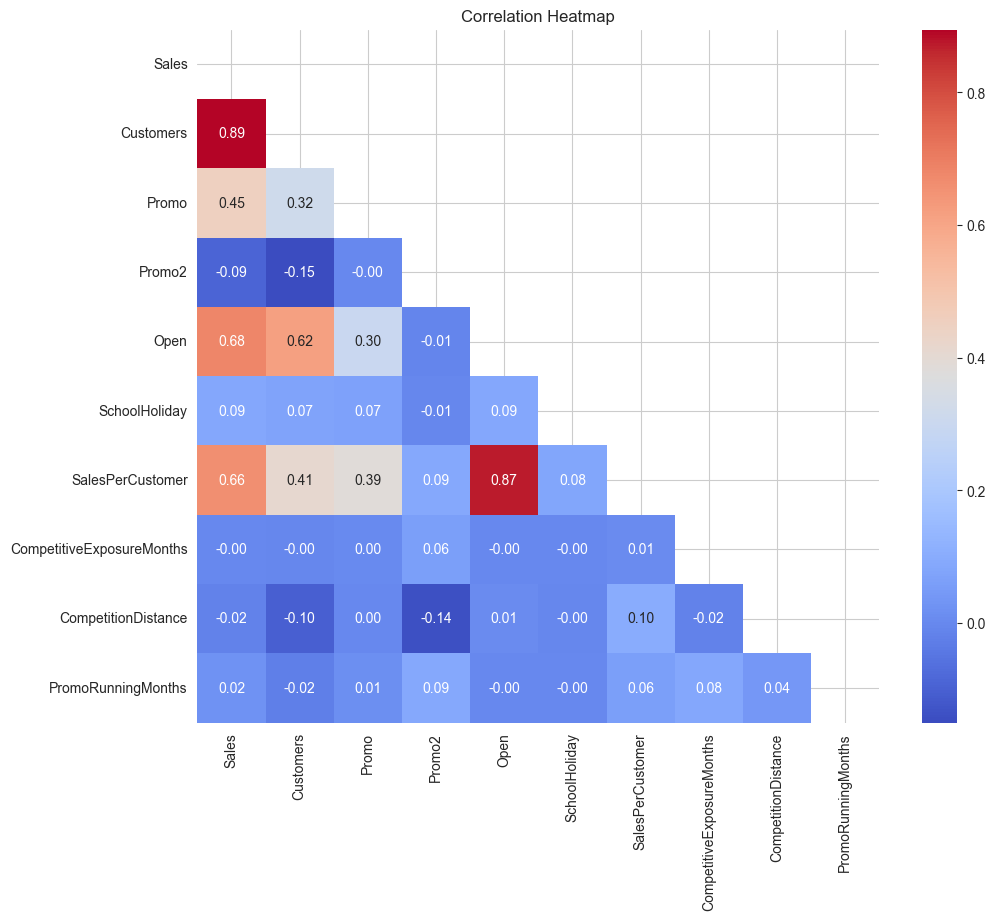

In [37]:
correlation_matrix = full_data[['Sales', 'Customers', 'Promo', 'Promo2', 'Open', 'SchoolHoliday', 'SalesPerCustomer', 'CompetitiveExposureMonths', 'CompetitionDistance', 'PromoRunningMonths']].corr()
upper_mask = np.zeros_like(correlation_matrix, dtype = np.bool)
upper_mask[np.triu_indices_from(upper_mask)] = True

fig, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(correlation_matrix, mask=upper_mask, annot=True, ax=ax, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

We can see that customers and sales are strongly correlated, which makes sense. More customers through the door generally correlates with higher sales. Promo and Sales are also correlated, which checks out. Notably, Promo2 (which indicates if the store is consecutively running a promo) is negatively correlated with sales! This indicates that when a store first starts offering a promo, sales and customer traffic goes up. But if they continue that promotion, sales and customer traffic starts to decrease. Let's see if this holds true at more granular levels, like successive days of the week:

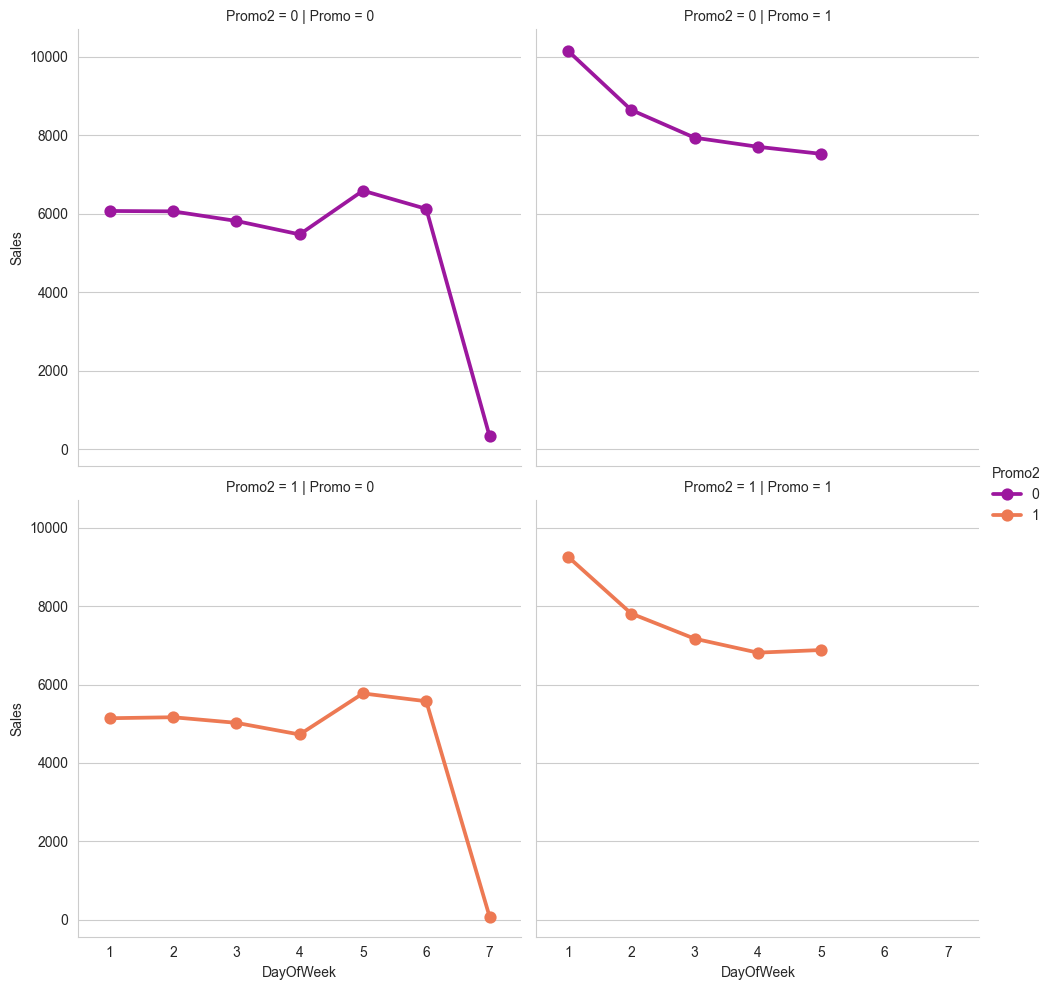

In [38]:
sns.catplot(data = full_data, x = 'DayOfWeek', y = "Sales", 
            kind='point',
            col = 'Promo', 
            row = 'Promo2',
            hue = 'Promo2',
            palette = 'plasma')

Indeed, a consecutive promo seems to decrease sales each successive day that the promo is run. With all of this in mind, let's start to build our forecasting models:

## Linear Regression

Linear regression takes in multiple input features and uses those to predict a straight line that forecasts sales in the future. With multiple linear regression, we could make this pretty complex: categorical encoding, data scaling, generating realistic future data to predict on, etc. With an eye towards just showing the limitations of linear regression, we're going to oversimply and over-abstract: input time series, output sales. Super simple.

We'll select a random store ID, fit a linear model to it, and predict for 6 weeks into the future:

In [71]:
from sklearn.linear_model import LinearRegression

def simple_linear_trend(df: pd.DataFrame, store_id: int):
    store_df = df[df['Store'] == store_id].copy()
    store_df['Date'] = pd.to_datetime(store_df[['Year', 'Month', 'Day']])
    # Sort by date to ensure time series order
    store_df = store_df.sort_values('Date').reset_index(drop=True)

    # Convert date to an int (ordinal)
    # Days since January 1 of year 1, Gregorian calendar
    X = store_df['Date'].map(lambda d: d.toordinal()).values.reshape(-1, 1)
    y = store_df['Sales'].values

    model = LinearRegression()
    model.fit(X, y)

    min_date, max_date = store_df['Date'].min(), store_df['Date'].max()
    return model, min_date, max_date


def predict_future_sales(model: LinearRegression, start_date: pd.Timestamp, num_days: int):
    future_dates = [start_date + pd.Timedelta(days=i) for i in range(1, num_days + 1)]
    future_ordinal = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)

    predicted_sales = model.predict(future_ordinal)

    return pd.DataFrame({'Date': future_dates,
                         'PredictedSales': predicted_sales})

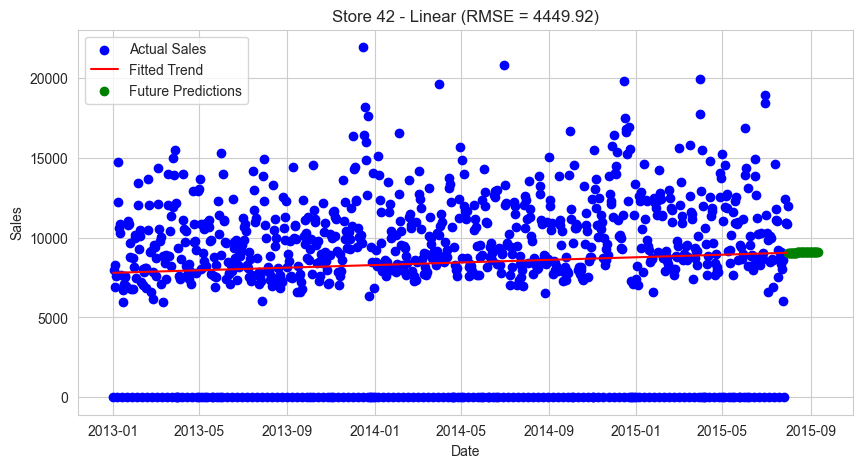

In [ ]:
from sklearn.metrics import root_mean_squared_error

selected_store_id = int(42)

# Get fitted linear model
model, min_date, max_date = simple_linear_trend(full_data, store_id=selected_store_id)

# Predict 6 weeks into the future
predictions = predict_future_sales(model, start_date=max_date, num_days=42)

# Get RMSE
selected_store_df = full_data[full_data['Store'] == selected_store_id].copy()
selected_store_df['Date'] = pd.to_datetime(selected_store_df[['Year', 'Month', 'Day']])
y_true = selected_store_df['Sales'].values
x_ord = selected_store_df['Date'].map(lambda d: d.toordinal()).values.reshape(-1, 1)
y_fit = model.predict(x_ord)
linear_rmse = root_mean_squared_error(y_true, y_fit)

# Plot actual sales
plt.figure(figsize=(10,5))
plt.scatter(selected_store_df['Date'], y_true, color='blue', label='Actual Sales')
plt.plot(selected_store_df['Date'], y_fit, color='red', label='Fitted Trend')

# Plot predictions
plt.scatter(predictions['Date'], predictions['PredictedSales'], color='green', label='Future Predictions')
plt.plot(predictions['Date'], predictions['PredictedSales'], color='green')

plt.title(f'Store {str(selected_store_id)} - Linear (RMSE = {linear_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

At the right end of our chart, we can see our predicted sales. These predictions are only valuable when we can compare them against a baseline. The nature of predicting future sales means we have no comparison baseline, so we'll use RMSE as a proxy evaluation. In this model, the predicted sales amounts differ by an average of $4,449.92. Let's check the mean, range, and standard deviation of our actual sales data, to get a sense of whether that RMSE is good or bad:

In [73]:
actual_mean = selected_store_df['Sales'].mean()
actual_range = (selected_store_df['Sales'].min(), selected_store_df['Sales'].max())
actual_std = selected_store_df['Sales'].std()

print(f'Mean: {actual_mean:.2f}')
print(f'Range: {actual_range[0]}-{actual_range[1]}')
print(f'Std Deviation: {actual_std:.2f}')
print(f'RMSE: {linear_rmse:.2f}')

Mean: 8416.95
Range: 0-21915
Std Deviation: 4467.07
RMSE: 4449.92


In this context, an RMSE of $4449 is quite large. On average, our model is off by about 1 full standard deviation! This error is possibly due to multiple factors: the prescence of closed store days, seasonality, and the fact that this model only has 1 input feature. Clearly, a linear model isn't granular enough to handle much variability. Let's see how much better a dedicated time-series model performs:

## SARIMA

Sarima, which stands for Seasonal Autoregressive Integrated Moving Average, is a widely used time series forecasting model. It's an extension of the non-seasonal ARIMA model, and adds the ability to handle data with seasonal patterns. SARIMA uses a combo of repeated seasons, autocorrelation, and moving averages to accurately model time series data. To build a SARIMA model, we need to check a few aspects of the data. First, we need to verify that the data is stationary. 

Stationarity refers to the statistical properties of time series data (like mean, variance, etc) remaining constant over time. This is crucial because if the data is non-stationary, SARIMA will struggle to find repeated seasons and patterns within the data. To check that the data is stationary, we can use the Dickey-Fuller test:

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

selected_store_df.set_index('Date', inplace=True)
selected_store_df.sort_index(inplace=True) # sort earliest to latest
time_series = selected_store_df['Sales']


def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")


adf_test(time_series)


ADF Statistic: -5.3036846554379276
p-value: 5.380238290624719e-06
Critical Value (1%): -3.4374778690219956
Critical Value (5%): -2.864686684217556
Critical Value (10%): -2.5684454926748583
The time series is stationary.


Looks like we're good on that front. Next, we'll check for autocorrelation and partial autocorrelation. Autocorrelation measures the relationship between a data point and previous data points at different lag intervals. Partial autocorrelation measures the correlation between a data point and a lag while adjusting for the influence of other lags:

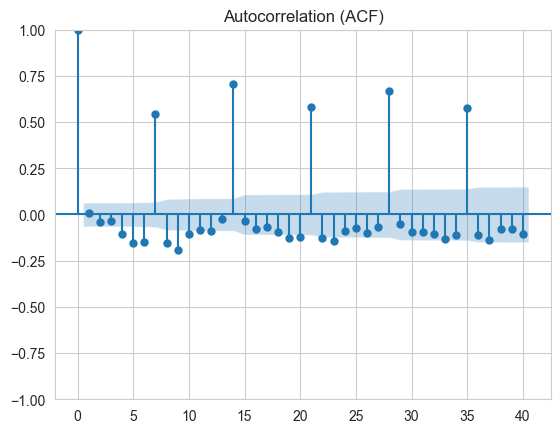

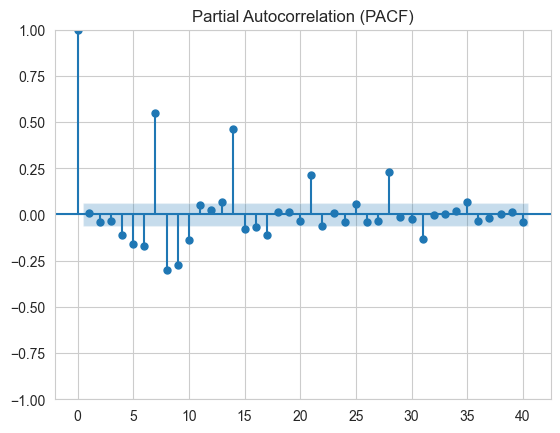

In [76]:
plot_acf(time_series, lags=40, title='Autocorrelation (ACF)')
plot_pacf(time_series, lags=40, title='Partial Autocorrelation (PACF)')
plt.show()

In [77]:
print(type(time_series))
print(time_series)

<class 'pandas.core.series.Series'>
Date
2013-01-01        0
2013-01-02     7959
2013-01-03     6925
2013-01-04     8273
2013-01-05     7587
              ...  
2015-07-27    12420
2015-07-28    10896
2015-07-29    10932
2015-07-30    10853
2015-07-31    11946
Name: Sales, Length: 942, dtype: int64


Each of these plots have a horizontal axis that shows the lags, and a vertical axis that shows the correlation values. -1 means strong negative correlation, 0 means no correlation, and 1 means strong positive correlation. The shaded area indicates the confidence interval for each correlation value. If the correlation value at a given lag is outside of the confidence interval, it means the value is statistically significant and not due to chance. We can see that most lags are not significantly correlated, but at regular intervals, a significant spike occurs. This indicates a level of seasonality, and tells us that SARIMA will be a good fit for our data. For brevity sake, I'm going to gloss over a lot of the math behind the hyperparameters. Let's build the model: 

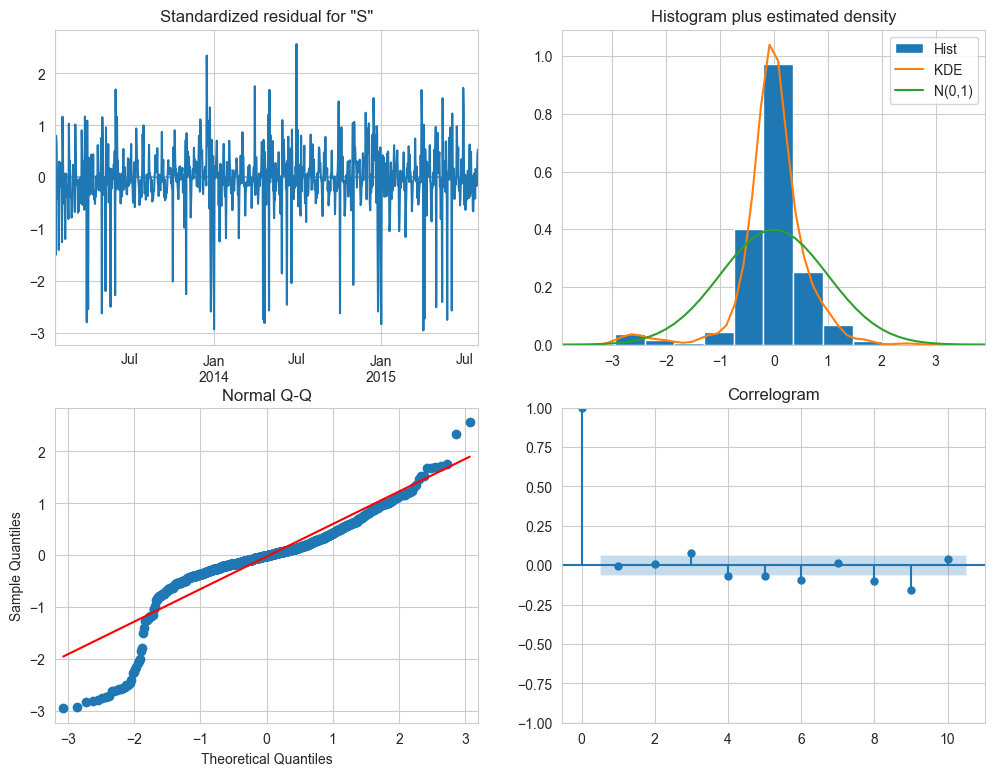

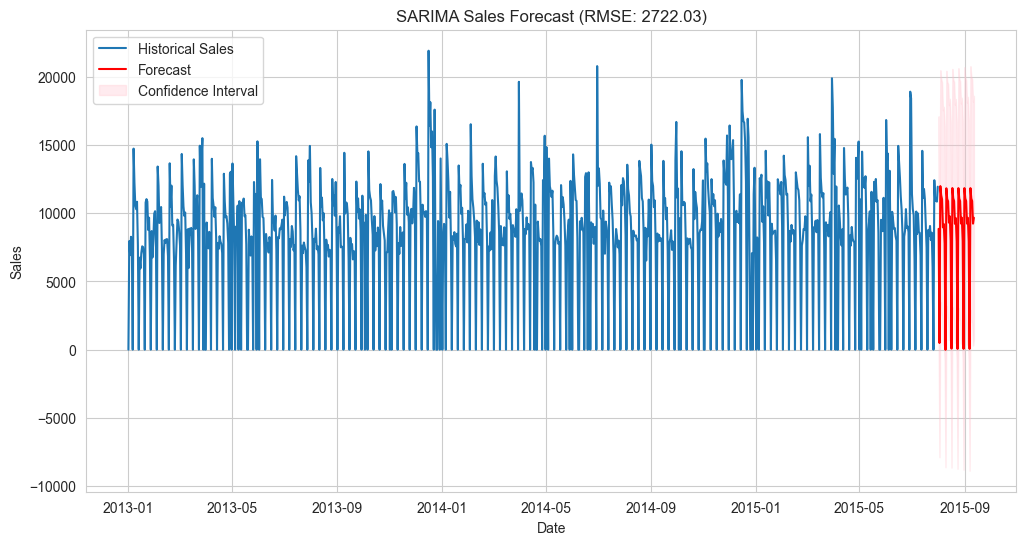

In [78]:
# Define hyperparameters
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 7  # assuming weekly seasonality

sarima_model = SARIMAX(time_series, 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, s), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

# Fit model
fitted_sarima = sarima_model.fit(disp=False)

# Get y_pred values and RMSE
sarima_y_pred = fitted_sarima.predict()
sarima_rmse = root_mean_squared_error(time_series, sarima_y_pred)

# Plot model summary and diagnostics
fitted_sarima.summary()
fitted_sarima.plot_diagnostics(figsize=(12, 9))
plt.show()

# Forecast 6 weeks of future sales
forecast_steps = 42
forecast = fitted_sarima.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Historical Sales')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'SARIMA Sales Forecast (RMSE: {sarima_rmse:.2f})')
plt.legend()
plt.show()

There's a lot of data here, so lets break it all down. 
- The top right plot shows the model's residuals: the differences between the actual value and the predicted value. A good model should have residuals randomly scattered around 0, and the residuals should all be roughly the same amount. In essence, the graph should look like a white noise waveform. Our residuals look ok, but there are some significant deviations at semi-regular intervals that indicate outlier values that the model can't handle. Notably, SARIMA under-predicts on the holiday shopping days.
- The top right plot shows the residuals compared to a normal bell curve. An optimal model should have have a residual density that looks more or less like the bell curve. Significant skewing or large tails indicate that the model isn't picking up on some outlier values. Our orange line looks mostly like a bell curve, but there is a big change between -2 and -3 standard deviations. This indicates that our model is not seeing some outlier high values. Maybe it's missing the holiday shopping spikes?
- The bottom left plot shows the same residual distribution data as the top right plot, but in a linear format. An optimal model's predictions should all fall along the red line. We see a similar drift at the lower standard deviations, which matches up with what we see in the residual histogram.
- The bottom right plot shows the autocorrelation of residuals at different lags. A good model should have no significant spikes aside from 0, and all correlations should be within the shaded significance boundary. We can see some larger spikes around a lag of 9 and 10, but nothing major.

The large bottom plot shows our actual sales data with our predicted values on the far right side. We can see that SARIMA is picking up on the weekly schedule of being closed on Sundays, but the confidence interval is large--anywhere between -8000 (impossible) and +20000. Additionally, our model doesn't seem to be seeing some of the spikes each month. Our RMSE is 2722.03, which is certainly better than the linear model, but it's still pretty high. On average, SARIMA is off by about 1/2 a standard deviation. No matter how tight our SARIMA model gets, it's still only using date as an input. To accurately predict the future, we need to account for a lot more than just the date. Enter deep learning:

## Deep Learning

Deep learning is an umbrella term for a group of statistical models that imitate the interconnected neuron paths of the human brain. LLMs, transformers, LSTMs, RNNs, and other major architectures are all specialized types of deep learning. Deep learning models (neural networks) use a complex web of parameters that are recursively adjusted via backpropogation to iteratively 'learn' the training data. By incorporating layers for activation functions and regularization, NNs can learn intricate, non-linear patterns across a variety of input features. Unlike our linear model, which assumed a linear relationship between the input feature and the sales output, NNs can model nonlinear relationships, interactions between features, and handle high-dimensional inputs with both categorical and numerical data. Likewise, NNs generally outperform SARIMA models due to their ability to handle high-dimensional data and exogenous (external) predictors. 

To build our model, we'll 
1. Encode our categorical inputs and scale our numerical inputs
2. Split our data into train and test sets
3. Build the model itself with linear, non-linear ReLU, and dropout regularization layers
4. Train the model on the training data
5. Construct some fake future input data and predict 6 weeks of future sales

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define categorical and numerical features
categorical_features = ["StateHoliday", "StoreType", "Assortment", "PromoInterval"]
numerical_features = ["Store", "DayOfWeek", "Customers", "Open", "Promo", "SchoolHoliday", "Year",
                      "Month", "Day", "WeekOfYear", "CompetitionDistance", "CompetitionOpenSinceMonth",
                      "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Promo2SinceYear",
                      "SalesPerCustomer", "CompetitiveExposureMonths", "PromoRunningMonths"]

# Separate inputs and target
X = selected_store_df.drop(columns=["Sales"])
y = selected_store_df["Sales"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), numerical_features),
                  ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)])
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Execute preprocessing pipeline
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Convert data to tensor
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# DataLoaders for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [85]:
# Define model
class SalesForecastingModel(nn.Module):
    def __init__(self, input_dim):
        super(SalesForecastingModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128), # linear input
            nn.ReLU(), # ReLU activation
            nn.Dropout(0.3), # dropout regularization
            nn.Linear(128, 64), # linear layer
            nn.ReLU(), # ReLU activation
            nn.Dropout(0.3), # dropout regularization
            nn.Linear(64, 32), # linear layer
            nn.ReLU(), # ReLU activation
            nn.Linear(32, 1) # linear output
        )

    def forward(self, x):
        return self.fc(x)

# Init model
input_dim = X_train_preprocessed.shape[1]
model = SalesForecastingModel(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad() # zero all gradients
            outputs = model(X_batch) # forward pass
            loss = criterion(outputs, y_batch) # compute loss
            loss.backward() # backprop
            optimizer.step() # update params
            running_loss += loss.item() # update current loss

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Train model
train_model(model, train_loader, criterion, optimizer, epochs=50)

# Eval loop
def evaluate_model(model, test_loader, criterion):
    model.eval() # set model to eval mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            all_predictions.append(outputs.squeeze().cpu())
            all_targets.append(y_batch.squeeze().cpu())
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

    all_predictions = torch.cat(all_predictions) # convert to tensor
    all_targets = torch.cat(all_targets) # convert to tensor

    mse = nn.MSELoss()(all_predictions, all_targets)
    print(f"Test MSE Loss: {total_loss / len(test_loader):.4f}")
    return mse

# Eval model
mse_loss = evaluate_model(model, test_loader, criterion)
dl_rmse = torch.sqrt(mse_loss).item()

print(f"RMSE: {dl_rmse:.2f}")

# Save model
torch.save(model.state_dict(), "sales_forecasting_model.pth")


Epoch 1/50, Loss: 90974444.6667
Epoch 2/50, Loss: 90009481.6667
Epoch 3/50, Loss: 90372744.6667
Epoch 4/50, Loss: 85680059.8333
Epoch 5/50, Loss: 76025609.6667
Epoch 6/50, Loss: 54759324.7500
Epoch 7/50, Loss: 26395275.1250
Epoch 8/50, Loss: 5636079.4375
Epoch 9/50, Loss: 2338458.9635
Epoch 10/50, Loss: 2154378.8125
Epoch 11/50, Loss: 2283064.0781
Epoch 12/50, Loss: 2143770.7188
Epoch 13/50, Loss: 2041386.2083
Epoch 14/50, Loss: 1974751.6745
Epoch 15/50, Loss: 1840314.3411
Epoch 16/50, Loss: 1942936.2786
Epoch 17/50, Loss: 1719995.9036
Epoch 18/50, Loss: 1936241.6094
Epoch 19/50, Loss: 2006741.4635
Epoch 20/50, Loss: 1717826.1536
Epoch 21/50, Loss: 1608336.0104
Epoch 22/50, Loss: 1740867.9167
Epoch 23/50, Loss: 1811064.3307
Epoch 24/50, Loss: 1842086.7812
Epoch 25/50, Loss: 1680334.7578
Epoch 26/50, Loss: 1697005.2578
Epoch 27/50, Loss: 1794430.6797
Epoch 28/50, Loss: 1642261.0964
Epoch 29/50, Loss: 1537123.5260
Epoch 30/50, Loss: 1647753.4740
Epoch 31/50, Loss: 1429383.3646
Epoch 32/5

## Bonus: Prophet